# Diabetic Retinopathy Severity Classification

- Importing required libraries


In [1]:
import random
from pathlib import Path
from PIL import Image


- Gathering all jpg paths for class “4” to sample an example and verify our directory parsing.  
- Randomly selecting and opening an image, we confirm the file path, class label, and image dimensions are correctly extracted before further processing.


Image path: D:\Documents\archive\dr_unified_v2\dr_unified_v2\train\4\6907_left.jpg
Image class: 4
Image width: 1023
Image height: 1024


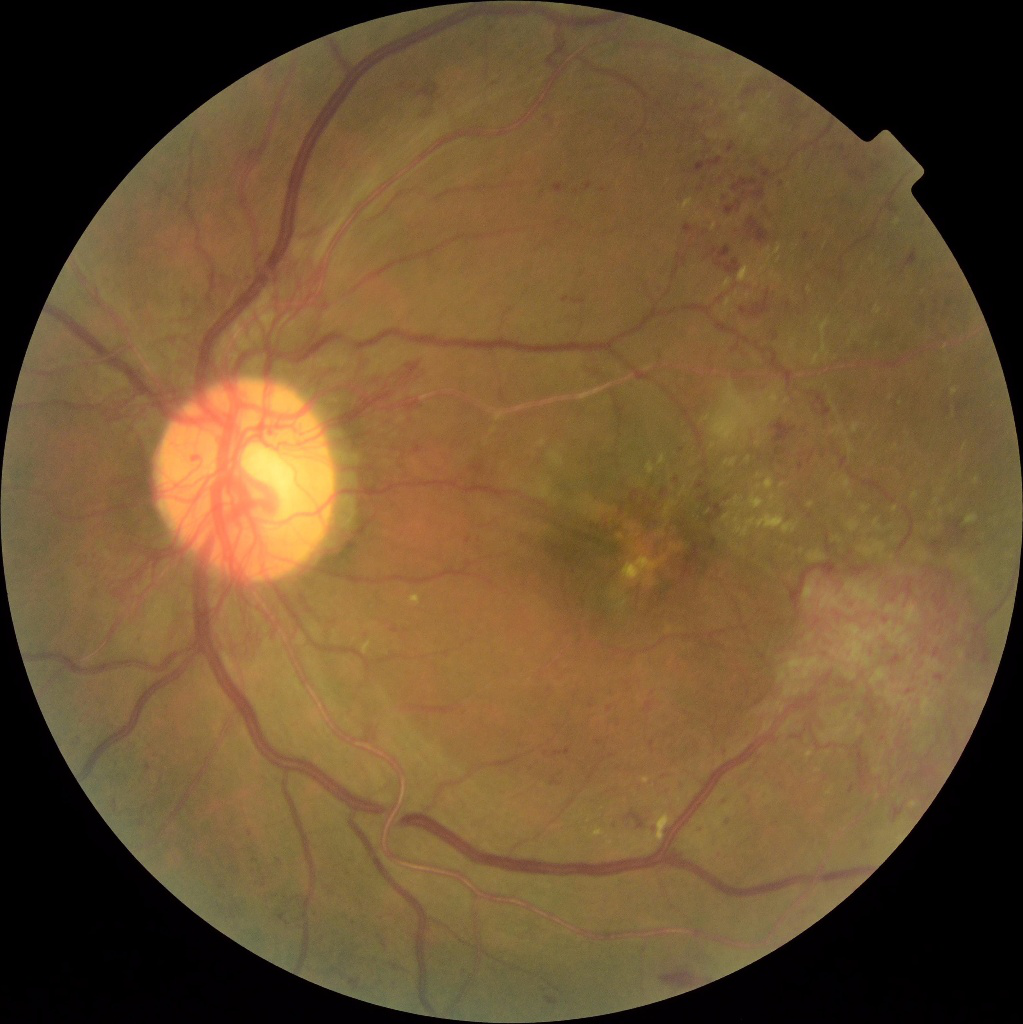

In [54]:
image_path = Path("D:/Documents/archive/dr_unified_v2/dr_unified_v2")

image_path_list = list(image_path.glob("*/4/*.jpg"))
image_path_list

random_image_path = random.choice(image_path_list)
random_image_path

image_class = random_image_path.parent.stem
#print(image_class)

img = Image.open(random_image_path) 

print(f"Image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image width: {img.width}")
print(f"Image height: {img.height}")
img

- Converting the image to a NumPy array and plotting it with Matplotlib lets us visually inspect the pixel data, verify the image shape, and ensure the class label matches what we expect before moving on to automated feature extraction.


(-0.5, 1022.5, 1023.5, -0.5)

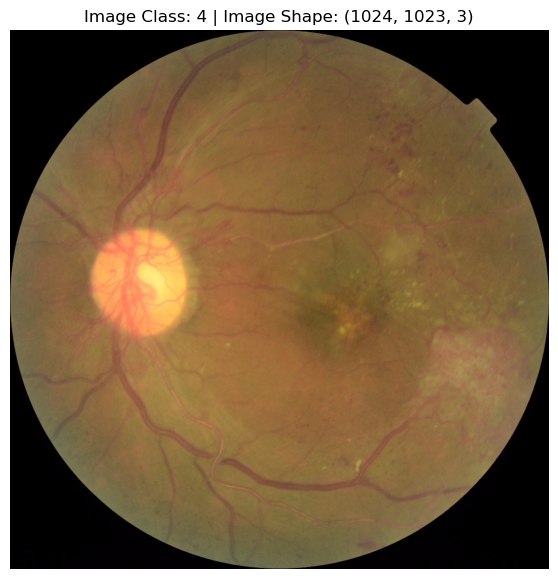

In [56]:
import matplotlib.pyplot as plt
import numpy as np
image = np.asarray(img)

plt.figure(figsize = (10, 7))
plt.imshow(image)
plt.title(f"Image Class: {image_class} | Image Shape: {image.shape}")
plt.axis(False)

- Counting the number of images per class lets us quickly assess the dataset balance and identify any class imbalances that could impact model performance.


In [40]:
import os
class_dir = "D:/Documents/archive/dr_unified_v2/dr_unified_v2/train"
classes = os.listdir("D:/Documents/archive/dr_unified_v2/dr_unified_v2/train")

class_counts = {}

for cls in classes:
    cls_folder = os.path.join(class_dir, cls)
    if os.path.isdir(cls_folder):
        class_counts[cls] = len(os.listdir(cls_folder))

print(class_counts)

{'0': 55162, '1': 3706, '2': 12119, '3': 1006, '4': 2002}


- Visualizing the class distribution helps us identify any imbalance in the dataset, which is crucial for choosing appropriate sampling or weighting strategies during model training.


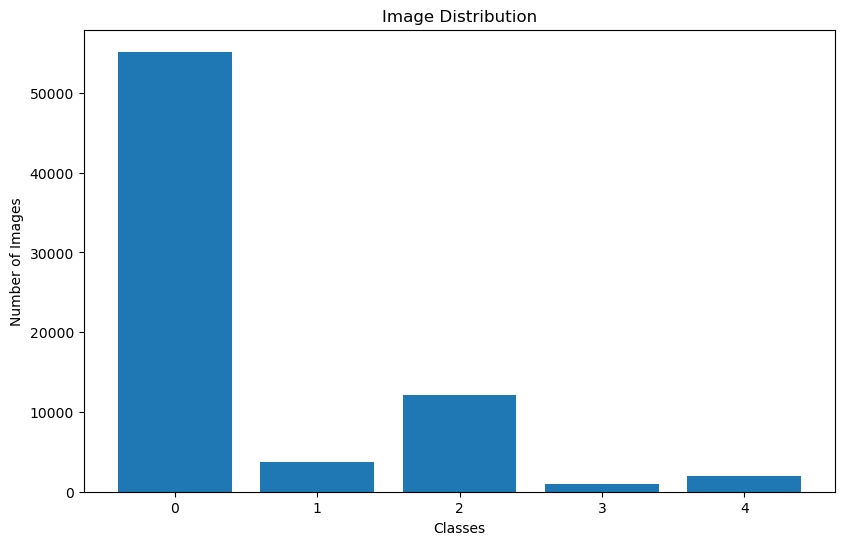

In [42]:
plt.figure(figsize = (9.7, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Image Distribution')
plt.show()

- Defined a standard preprocessing pipeline resizing all images to 224×224 (model input size), adding random flips for data augmentation, converting to tensor, and normalizing with EfficientNetB0 statistics so that our network sees consistent, well‑scaled inputs and learns more robust features.  


In [44]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

- The PIL image—resizing, augmentation, normalization and then permutes the tensor from (C, H, W) to (H, W, C) so Matplotlib can display the transformed image, letting us visualize the preprocessing.  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


(-0.5, 223.5, 223.5, -0.5)

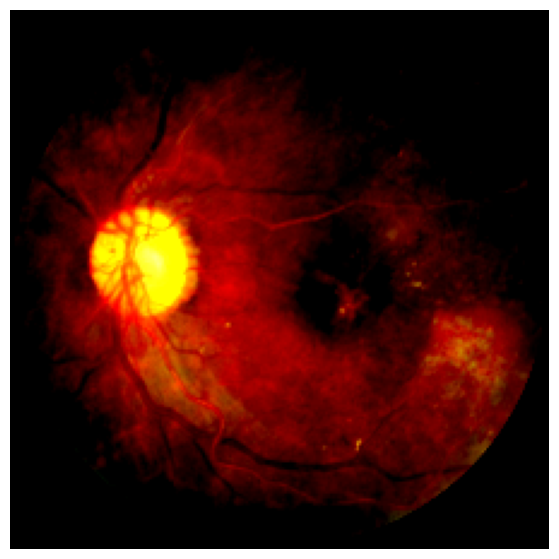

In [76]:
transformed_img = transform(img)
plt.figure(figsize = (10, 7))
plt.imshow(transformed_img.permute(1, 2, 0))
plt.axis(False)


- Defining Path objects for the three dataset splits— train, test and validation so that later steps can reference these directories directly and clearly.  


In [60]:
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"
train_dir, test_dir, val_dir

(WindowsPath('D:/Documents/archive/dr_unified_v2/dr_unified_v2/train'),
 WindowsPath('D:/Documents/archive/dr_unified_v2/dr_unified_v2/test'),
 WindowsPath('D:/Documents/archive/dr_unified_v2/dr_unified_v2/val'))

### Create PyTorch `ImageFolder` Datasets  
Used datasets.ImageFolder to automatically label and load all images under each split directory (train, test, val), applying the same preprocessing (transform) so that our DataLoader can later batch them for model training and evaluation.  


In [64]:
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = transform
                                 )
test_data = datasets.ImageFolder(root = test_dir,
                                 transform = transform
                                )
val_data = datasets.ImageFolder(root = val_dir,
                                transform = transform)
train_data, test_data, val_data

(Dataset ImageFolder
     Number of datapoints: 73995
     Root location: D:\Documents\archive\dr_unified_v2\dr_unified_v2\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 9261
     Root location: D:\Documents\archive\dr_unified_v2\dr_unified_v2\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 Dataset ImageFolder
     Number of datapoints: 9245
     Root location: D:\Documents\archive\dr_unified_v2\dr_unified_v2\val
     S

### Create DataLoaders for Batching and Shuffling  
We wrap each dataset in a DataLoader so that during training we process images in mini‐batches (size 32), shuffle the training set each epoch to improve generalization, and keep validation/test sets in fixed order for consistent evaluation. Calling len(train_loader) gives the number of training batches per epoch.  


In [128]:
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True)
val_loader = DataLoader(val_data,
                        batch_size=32,
                        shuffle=False)
test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False)
len(train_loader)

2313

In [110]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Initialize and Customize EfficientNet-B0  
Load a pretrained EfficientNet‑B0 backbone, replace its final classification layer to output 5 DR severity classes, and move the model to the GPU for training.  


In [112]:
from torchvision.models import efficientnet_b0
from torch import nn

model = efficientnet_b0(weights='IMAGENET1K_V1')
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 5)
model = model.to(device)

- Compute inverse‑frequency class weights for imbalance, plug them into CrossEntropyLoss, train with Adam at 1e‑4, and load accuracy function from a pre built file called 'helper_functions.py'.

In [120]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", 
                                     classes=np.unique(train_data.targets), 
                                     y=np.array(train_data.targets))

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
from helper_functions import accuracy_fn

- Computes the elapsed time, and prints it—allowing to profile and benchmark any code block.


In [121]:
from timeit import default_timer as timer
def time(start: float,
         end: float):
    total_time = end - start
    print(f"Timer: {total_time} seconds")


### Training & Validation Loop  
Runs through epochs of batched training (forward pass, loss computation, backpropagation, optimizer step) on train_loader, logs progress every 600 batches, then switches to evaluation mode on val_loader to compute validation loss, accuracy, and macro F1 score—finally reporting both training and validation metrics and total elapsed time.  


In [132]:
from sklearn.metrics import f1_score
timer_start = timer()
EPOCHS = 5

for epoch in range (EPOCHS):
    print(f"Epochs: {epoch + 1}\n----")
    train_loss = 0
    train_acc = 0
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)
        y = y.to(device)
        model.train()
        #Forward pass
        y_logits = model(X)
        y_preds = y_logits.argmax(dim = 1)
        #Calculate loss
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()
        #Calculate accuracy
        acc = accuracy_fn(y_true = y,
                          y_pred = y_preds)
        train_acc += acc

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 600 == 0:
            print(f"Looked at {batch} out of {len(train_loader)} samples")
            
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)

    model.eval()
    val_loss = 0
    val_acc = 0
    all_preds = []
    all_labels = []
    with torch.inference_mode():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            
            #Forward pass
            val_logits = model(X_val)
            val_preds = val_logits.argmax(dim = 1)
            #Calculate loss
            loss = loss_fn(val_logits, y_val)
            val_loss += loss.item()
            #Calculate accuracy
            acc = accuracy_fn(y_true = y_val,
                              y_pred = val_preds)
            val_acc += acc

            all_preds.extend(val_preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())
            
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_f1 = f1_score(all_labels, all_preds, average='macro')
        
    print(f"\nTrain Loss: {train_loss} | Train accuracy {train_acc}")
    print(f"Validation Loss: {val_loss} | Validation accuracy {val_acc} | Validation F1 score {val_f1}")

         
timer_end = timer()
time(start = timer_start,
     end = timer_end)

Epochs: 1
----
Looked at 0 out of 2313 samples
Looked at 600 out of 2313 samples
Looked at 1200 out of 2313 samples
Looked at 1800 out of 2313 samples

Train Loss: 1.1647112928733545 | Train accuracy 59.233384427936954
Validation Loss: 0.85909964427816 | Validation accuracy 70.10462653621286 | Validation F1 score 0.4431790500417634
Epochs: 2
----
Looked at 0 out of 2313 samples
Looked at 600 out of 2313 samples
Looked at 1200 out of 2313 samples
Looked at 1800 out of 2313 samples

Train Loss: 1.0065605558335806 | Train accuracy 64.34345890814762
Validation Loss: 0.8088843573954692 | Validation accuracy 69.42302529531082 | Validation F1 score 0.4967178966842699
Epochs: 3
----
Looked at 0 out of 2313 samples
Looked at 600 out of 2313 samples
Looked at 1200 out of 2313 samples
Looked at 1800 out of 2313 samples

Train Loss: 0.9134088838146819 | Train accuracy 66.35764257359588
Validation Loss: 0.8334976220729029 | Validation accuracy 66.11010022670327 | Validation F1 score 0.4643852547237

### Evaluating model  
Runs the trained model in evaluation mode on the CPU over every batch in `test_loader`, collects the predicted class indices and true labels for the entire test set by concatenating batch-wise tensors into `test_preds` and `y`.  


In [142]:
test_preds = []
y = []
model.to('cpu')
for X_true, y_true in test_loader:
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_true)
        test_pred = test_logits.argmax(dim = 1)

        #test_pred, y_true = test_pred.to('cpu'), y_true.to('cpu')
        test_preds.append(test_pred)
        y.append(y_true)
        
test_preds = torch.cat(test_preds)
y = torch.cat(y)

### Confusion Matrix Calculation  
Imports the `confusion_matrix` function and plotting libraries, computes the confusion matrix between true labels (`y`) and model predictions (`test_preds`) to assess per‑class performance, and sets up human‑readable `class_names` for visualization.  


In [148]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y, test_preds)

# Optional: Define class names
class_names = ['0', '1', '2', '3', '4']

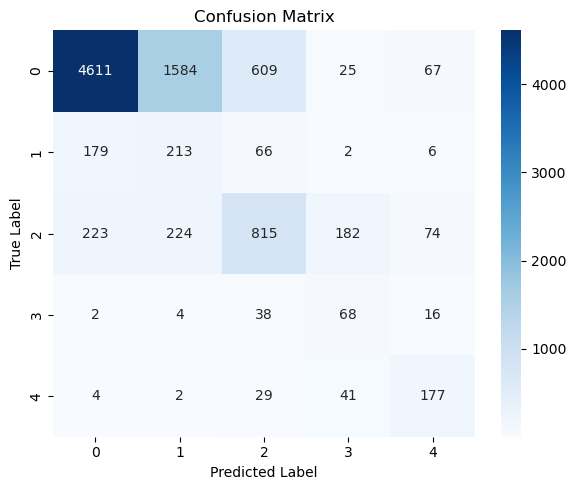

In [150]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Classification Report Generation  
Display precision, recall, F1‑score, and support for each DR severity class (0–4), summarizing model performance across all labels.  


In [168]:
from sklearn.metrics import classification_report
report = classification_report(y, test_preds, target_names=['0', '1', '2', '3', '4'])

print(report)


              precision    recall  f1-score   support

           0       0.92      0.67      0.77      6896
           1       0.11      0.46      0.17       466
           2       0.52      0.54      0.53      1518
           3       0.21      0.53      0.30       128
           4       0.52      0.70      0.60       253

    accuracy                           0.64      9261
   macro avg       0.46      0.58      0.48      9261
weighted avg       0.79      0.64      0.69      9261



**Save Trained Model**  
Creates a models folder, defines a filename, and writes out the PyTorch model’s learned weights to disk for later loading or deployment.  


In [ ]:
from pathlib import Path
# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,
                 exist_ok = True)
MODEL_NAME = "BigData_CNN.pth"

MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model.state_dict(),
           f = MODEL_SAVE_PATH
          )

Saving model to: models\BigData_CNN.pth


### Comparing execution times while scaling out
Execution times were obtailned by running the random forest model on GCP. These values were then plotted here for visualizing scaling out.

*The execution times in the below plot are not of this model.*

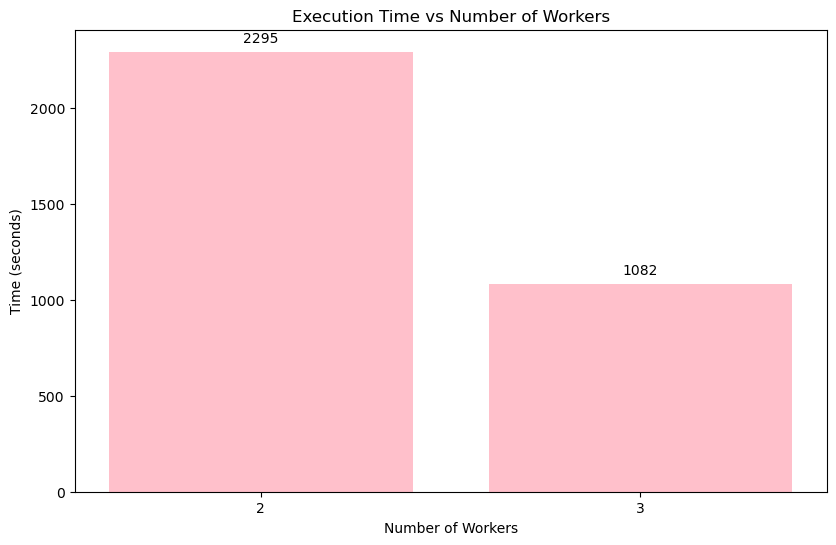

In [11]:
import matplotlib.pyplot as plt

# Data
workers = [2, 3]
time = [2295, 1082]

# Plot
plt.figure(figsize=(9.7, 6))
plt.bar(workers, time, color='pink')
plt.xlabel("Number of Workers")
plt.ylabel("Time (seconds)")
plt.title("Execution Time vs Number of Workers")

# Ensure only integer ticks on x-axis
plt.xticks(workers)

# Annotate values on top of bars
for i in range(len(workers)):
    plt.text(workers[i], time[i] + 50, str(time[i]), ha='center')

plt.show()